In [68]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

In [69]:
# 读取处理后的数据（原始 + 抖音）
df1 = pd.read_csv("../processed_data/processed_psi_data.csv")
df2 = pd.read_csv("../processed_data/processed_psi_douyin.csv")

# 取共同列合并
common_cols = list(set(df1.columns) & set(df2.columns))
df = pd.concat([df1[common_cols], df2[common_cols]], ignore_index=True)
print(f"原始: {len(df1)} 行, 抖音: {len(df2)} 行, 合并: {len(df)} 行")

原始: 3372 行, 抖音: 4692 行, 合并: 8064 行


In [70]:
# 裁剪 future 目标的极端异常值（避免少数 spike 主导训练）
upper = df["future_1s_some"].quantile(0.99)
print(f"future_1s_some 99th percentile: {upper:.0f}")
df["future_1s_some"] = df["future_1s_some"].clip(upper=upper)

# 按 source_file 分组计算 lag 特征（避免跨文件污染）
for lag in [1, 2, 3, 4, 6, 8]:
    df[f"some_lag_{lag}"] = df.groupby('source_file')['some_delta'].shift(lag)
    df[f"full_lag_{lag}"] = df.groupby('source_file')['full_delta'].shift(lag)
    df[f"pgscan_lag_{lag}"] = df.groupby('source_file')['pgscan_direct'].shift(lag)

# EWM 指数加权均值（近期趋势，衰减更平滑）
for span in [3, 6, 10]:
    df[f"some_ewm_{span}"] = df.groupby('source_file')['some_delta'].transform(
        lambda x: x.ewm(span=span).mean())
    df[f"mem_ewm_{span}"] = df.groupby('source_file')['mem_available'].transform(
        lambda x: x.ewm(span=span).mean())

# 比率特征
df["pgscan_steal_ratio"] = df["pgsteal_direct"] / (df["pgscan_direct"] + 1)
df["swap_net"] = df["pswpin"] - df["pswpout"]
df["mem_avail_pct_change"] = df.groupby('source_file')['mem_available'].pct_change()

# 删除因 shift/ewm 产生的 NaN 行
df = df.dropna().reset_index(drop=True)
print(f"特征增强后: {len(df)} 行, {len(df.columns)} 列")

future_1s_some 99th percentile: 250688
特征增强后: 8024 行, 55 列


In [71]:
# 按 source_file 分层，每个文件 80% 训练 20% 测试（避免分布偏移）
train_parts = []
test_parts = []
for name, group in df.groupby('source_file'):
    s = int(len(group) * 0.8)
    train_parts.append(group.iloc[:s])
    test_parts.append(group.iloc[s:])

train = pd.concat(train_parts).reset_index(drop=True)
test  = pd.concat(test_parts).reset_index(drop=True)
print(f"Train: {len(train)}, Test: {len(test)}")

Train: 6418, Test: 1606


In [72]:
# 删除不参与训练的列 
drop_cols = [
    "ts",
    "source_file",
    "future_1s_some",
    "future_1s_full"
]

feature_cols = [c for c in df.columns if c not in drop_cols]

In [73]:
# 构造训练数据 + 样本权重（spike 区间加权）
X_train = train[feature_cols]
y_train = np.log1p(train["future_1s_some"])

X_test  = test[feature_cols]
y_test  = np.log1p(test["future_1s_some"])

# 按 future_1s_some 大小分配权重：越大的 spike 权重越高
raw_y = train["future_1s_some"]
weights = np.ones(len(raw_y))
q75 = raw_y.quantile(0.75)
q90 = raw_y.quantile(0.90)
q95 = raw_y.quantile(0.95)
weights[raw_y > q75] = 3.0
weights[raw_y > q90] = 6.0
weights[raw_y > q95] = 10.0
print(f"样本权重分布: 1x={(weights==1).sum()}, 3x={(weights==3).sum()}, "
      f"6x={(weights==6).sum()}, 10x={(weights==10).sum()}")

样本权重分布: 1x=4813, 3x=963, 6x=321, 10x=321


In [74]:
# 训练 XGBoost 模型（sample_weight 加权 + early stopping）
model = xgb.XGBRegressor(
    n_estimators=2000,
    max_depth=6,
    learning_rate=0.02,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1.0,
    min_child_weight=3,
    gamma=0.1,
    random_state=42,
    early_stopping_rounds=80
)

model.fit(
    X_train, y_train,
    sample_weight=weights,
    eval_set=[(X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:4.18645
[100]	validation_0-rmse:2.26996
[200]	validation_0-rmse:2.09448
[300]	validation_0-rmse:2.04504
[400]	validation_0-rmse:2.02691
[500]	validation_0-rmse:2.01691
[600]	validation_0-rmse:2.00765
[700]	validation_0-rmse:2.00455
[800]	validation_0-rmse:2.00074
[868]	validation_0-rmse:2.00092


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",80
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

In [75]:
# 预测
pred = model.predict(X_test)

In [76]:
# 评估（log 尺度 + real 尺度 + 分类视角）
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

pred_real = np.expm1(pred)
y_real = np.expm1(y_test)

# 1) Log 尺度（模型直接优化的空间）
print("=== Log 尺度 ===")
print(f"  R2:  {r2_score(y_test, pred):.4f}")
print(f"  MSE: {mean_squared_error(y_test, pred):.4f}")

# 2) Real 尺度
print("\n=== Real 尺度 ===")
print(f"  R2:  {r2_score(y_real, pred_real):.4f}")
print(f"  MSE: {mean_squared_error(y_real, pred_real):.2f}")

# 3) 分类视角：用多个阈值评估 spike 检测能力
print("\n=== Spike 检测（分类视角）===")
print(f"  future_1s_some 分布: mean={y_real.mean():.0f}, median={y_real.median():.0f}, "
      f"75th={y_real.quantile(0.75):.0f}, 90th={y_real.quantile(0.9):.0f}, 95th={y_real.quantile(0.95):.0f}")

for q, label in [(0.75, "75th"), (0.90, "90th"), (0.95, "95th")]:
    thr = y_real.quantile(q)
    y_cls = (y_real > thr).astype(int)
    pred_cls = (pred_real > thr).astype(int)
    pos_rate = y_cls.mean()
    print(f"\n  阈值={thr:.0f} ({label}, 正样本率={pos_rate:.2%}):")
    print(f"    Accuracy:  {accuracy_score(y_cls, pred_cls):.4f}")
    print(f"    Precision: {precision_score(y_cls, pred_cls, zero_division=0):.4f}")
    print(f"    Recall:    {recall_score(y_cls, pred_cls, zero_division=0):.4f}")
    print(f"    F1:        {f1_score(y_cls, pred_cls, zero_division=0):.4f}")

=== Log 尺度 ===
  R2:  0.6058
  MSE: 3.9985

=== Real 尺度 ===
  R2:  0.4243
  MSE: 803787402.93

=== Spike 检测（分类视角）===
  future_1s_some 分布: mean=14739, median=962, 75th=8703, 90th=38914, 95th=86993

  阈值=8703 (75th, 正样本率=25.03%):
    Accuracy:  0.8412
    Precision: 0.6833
    Recall:    0.6816
    F1:        0.6824

  阈值=38914 (90th, 正样本率=10.02%):
    Accuracy:  0.9197
    Precision: 0.6455
    Recall:    0.4410
    F1:        0.5240

  阈值=86993 (95th, 正样本率=5.04%):
    Accuracy:  0.9589
    Precision: 0.6829
    Recall:    0.3457
    F1:        0.4590


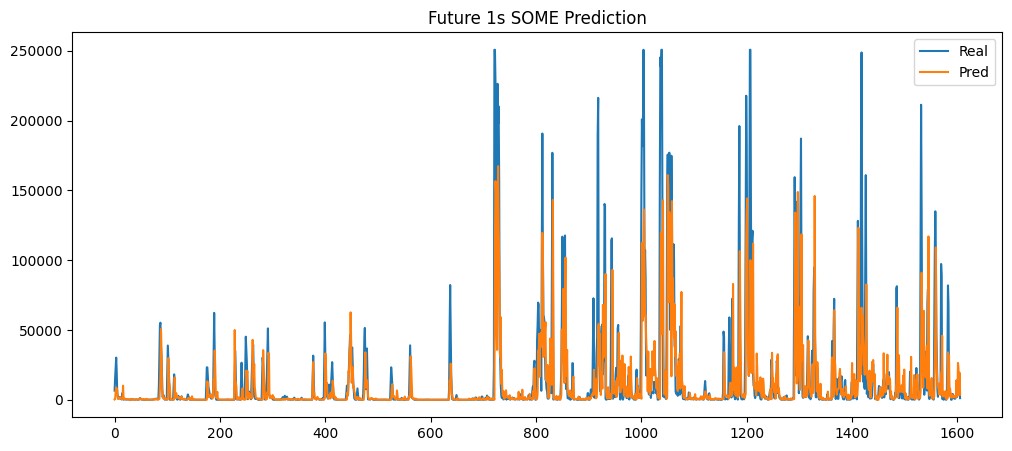

In [77]:
# 画图
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(np.expm1(y_test.values), label="Real")
plt.plot(np.expm1(pred), label="Pred")
plt.legend()
plt.title("Future 1s SOME Prediction")
plt.show()

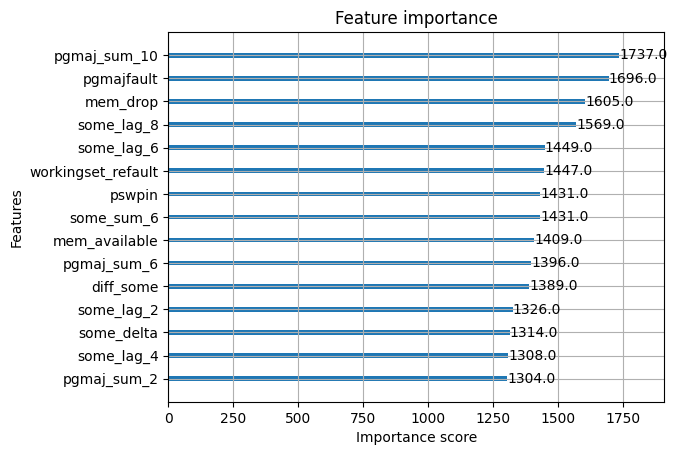

In [78]:
# 特征重要性
xgb.plot_importance(model, max_num_features=15)
plt.show()